In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time,os,gc,re
from tqdm import tqdm
from geohash import encode
from scipy.stats import skew
from geohash import encode
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

# 小区名正则过滤
name_filter=lambda x:re.sub(r'\(.*?\)', '', re.sub(r'\（.*?\）', '', x))
# 楼层映射
floor_map=lambda x:list(pd.cut(x,[0,3,6,9,np.inf],labels=['低层','多层','小高层','高层']))

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## 加载数据

In [3]:
# 读取挂牌数据
dfs=[]
for k in range(1,10):
    with open('/Users/wangdexun/Documents/gubbins/房价大数据/数据/2017挂牌数据/2017-0{}/挂牌.txt'.format(k)) as f:
        l=[]
        for i in tqdm(f.readlines()):
            l.append(i.split('\t'))
        meta_df=pd.DataFrame(l)
        _drop_col=[0,15,16,18,19,20,21]
        if k>=6:
            _drop_col.append(22)
        meta_df.drop(_drop_col,axis=1,inplace=True) # 去除无用列
        meta_df.columns=['area','address','name','price','unit_price','acreage','room_type','all_floor','floor','shore','house_type','fitment','time','Source','house_trait']
#         meta_df=meta_df[meta_df.Source=='链家']
        meta_df['month']=k
        dfs.append(meta_df)

100%|██████████| 499696/499696 [00:03<00:00, 149959.97it/s]


In [4]:
# 缓存
all_df=pd.concat(dfs,ignore_index=True)
all_df.to_hdf('./cache/guapai.hdf','data')

In [2]:
all_df=pd.read_hdf('./cache/guapai.hdf','data')
all_df.head()

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,house_type,fitment,time,Source,house_trait,month
0,长宁,番禺路222弄11支弄,番禺路222弄小区,3400000,72340,47.00,2室1厅1厨1卫,6,2,南北,公寓,中装修,1984-01-01,房天下,普通住宅,1
1,浦东,博兴路1676弄,东陆新村九街坊,2750000,51210,53.70,1室1厅1厨1卫,6,2,南北,公寓,精装修,2000-01-01,房天下,普通住宅,1
2,浦东,城南路359号,东都小区,1920000,39024,49.20,2室1厅1厨1卫,5,4,南北,公寓,中装修,1986-01-01,房天下,普通住宅,1
3,松江,明华路366弄102-1148号,绿洲比华利花园,18000000,42705,421.50,4室2厅1厨4卫,2,1,南,别墅洋房,精装修,2000-01-01,房天下,别墅,1
4,浦东,御青路328弄,民乐苑,2950000,57843,51.00,1室1厅1厨1卫,6,2,南,公寓,简装修,1996-01-01,房天下,普通住宅,1


In [68]:
# 获取经纬度信息
newdisk_df=pd.read_csv('../数据/GC_dbo_AD_NewDisk.csv',usecols=['NewDiskID','PropertyID','NewDiskName','Coordinates'])
newdisk_df.rename(columns={'NewDiskName':'name'},inplace=True)
newdisk_df.dropna(inplace=True)
newdisk_df.drop_duplicates('PropertyID',inplace=True)
newdisk_df.head()

,NewDiskID,PropertyID,name,Coordinates
0,1,14578,海伦国际大厦,"121.48593904918,31.268556126592"
1,2,14583,和源大楼,"121.47417360118,31.271112531812"
2,3,14584,财富中心,"121.46979487834,31.259056541178"
3,4,14602,科创动力,"121.42412471181,31.181237621707"
4,5,14613,绿地伯顿商务广场,"121.25327636955,31.022714501392"


In [69]:
# 获取板块、环线信息
property_df=pd.read_csv('../数据/GC_dbo_AD_Property.csv',usecols=['PropertyID','Area','Plate','Module','HousingName'])
property_df.rename(columns={'Area':'area','HousingName':'name'},inplace=True)
property_df.head()

,PropertyID,area,Plate,Module,name
0,1,嘉定,安亭汽车城,外环以外,澳丽映象嘉园
1,2,普陀,武宁,内环以内,浅水湾恺悦名城
2,3,徐汇,徐汇中心,内环以内,青松小区
3,4,浦东,洋泾,内环以内,巨洋小区
4,5,金山,石化,外环以外,海趣馨苑


In [8]:
# merge them
property_df=pd.merge(property_df,newdisk_df[['PropertyID','Coordinates']],on='PropertyID',how='inner')
property_df.head()

,PropertyID,area,Plate,Module,name,Coordinates
0,1,嘉定,安亭汽车城,外环以外,澳丽映象嘉园,"121.15659808595,31.31139200258"
1,2,普陀,武宁,内环以内,浅水湾恺悦名城,"121.44773671616,31.255725959165"
2,3,徐汇,徐汇中心,内环以内,青松小区,"121.45489281368,31.203688194162"
3,4,浦东,洋泾,内环以内,巨洋小区,"121.55264713792,31.244887868785"
4,5,金山,石化,外环以外,海趣馨苑,"121.34017951087,30.752088574465"


In [10]:
# 小区名称清洗
property_df.drop_duplicates(['area','name'],inplace=True)
property_df.name=property_df.name.apply(name_filter)
all_df.name=all_df.name.apply(name_filter)

In [113]:
# 合并信息
all_df=pd.merge(all_df,property_df,on=['name','area'],how='inner')
all_df.to_hdf('./cache/train.hdf','data')

In [2]:
all_df=pd.read_hdf('./cache/train.hdf','data')
all_df.head()

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,house_type,fitment,time,Source,house_trait,month,PropertyID,Plate,Module,Coordinates
0,浦东,城南路359号,东都小区,1920000.0,39024.0,49.2,2室1厅1厨1卫,5.0,4.0,南北,公寓,中装修,1986-01-01,房天下,普通住宅,1,4781,川沙,外环以外,"121.70855449796,31.198134594037"
1,浦东,城南路329弄,东都小区,1900000.0,38618.0,49.2,2室1厅1厨1卫,6.0,2.0,南北,公寓,中装修,1986-01-01,房天下,普通住宅,1,4781,川沙,外环以外,"121.70855449796,31.198134594037"
2,浦东,城南路341弄,东都小区,1920000.0,38400.0,50.0,2室1厅1厨1卫,6.0,2.0,南北,公寓,简装修,1992-01-01,房天下,普通住宅,1,4781,川沙,外环以外,"121.70855449796,31.198134594037"
3,浦东,城南路359号,东都小区,1850000.0,37000.0,50.0,1室1厅1厨1卫,6.0,6.0,南北,公寓,精装修,1983-01-01,房天下,普通住宅,1,4781,川沙,外环以外,"121.70855449796,31.198134594037"
4,浦东,城南路359号,东都小区,1920000.0,39184.0,49.0,2室1厅1厨1卫,5.0,4.0,南,公寓,中装修,1986-01-01,房天下,普通住宅,1,4781,川沙,外环以外,"121.70855449796,31.198134594037"


In [3]:
# 转换数值类型
numerical_columns=['price','unit_price','acreage','all_floor','floor'] # str->float
all_df[numerical_columns]=all_df[numerical_columns].astype(float)

In [4]:
all_df[numerical_columns].describe()

,price,unit_price,acreage,all_floor,floor
count,3.480067e+06,3.480067e+06,3.480067e+06,3.480067e+06,3.480067e+06
mean,5.548903e+06,5.504989e+04,9.601145e+01,1.110598e+01,5.283538e+00
std,7.559677e+06,2.932402e+04,7.650108e+01,8.573028e+00,5.555178e+00
min,4.500000e+01,2.798000e+03,2.100000e+00,0.000000e+00,-5.000000e+00
25%,2.700000e+06,4.042600e+04,5.611000e+01,6.000000e+00,2.000000e+00
50%,3.800000e+06,5.314800e+04,7.992000e+01,6.000000e+00,3.000000e+00
75%,6.000000e+06,6.590950e+04,1.090000e+02,1.500000e+01,6.000000e+00
max,9.999900e+08,1.101909e+07,4.388000e+03,9.000000e+01,6.300000e+01


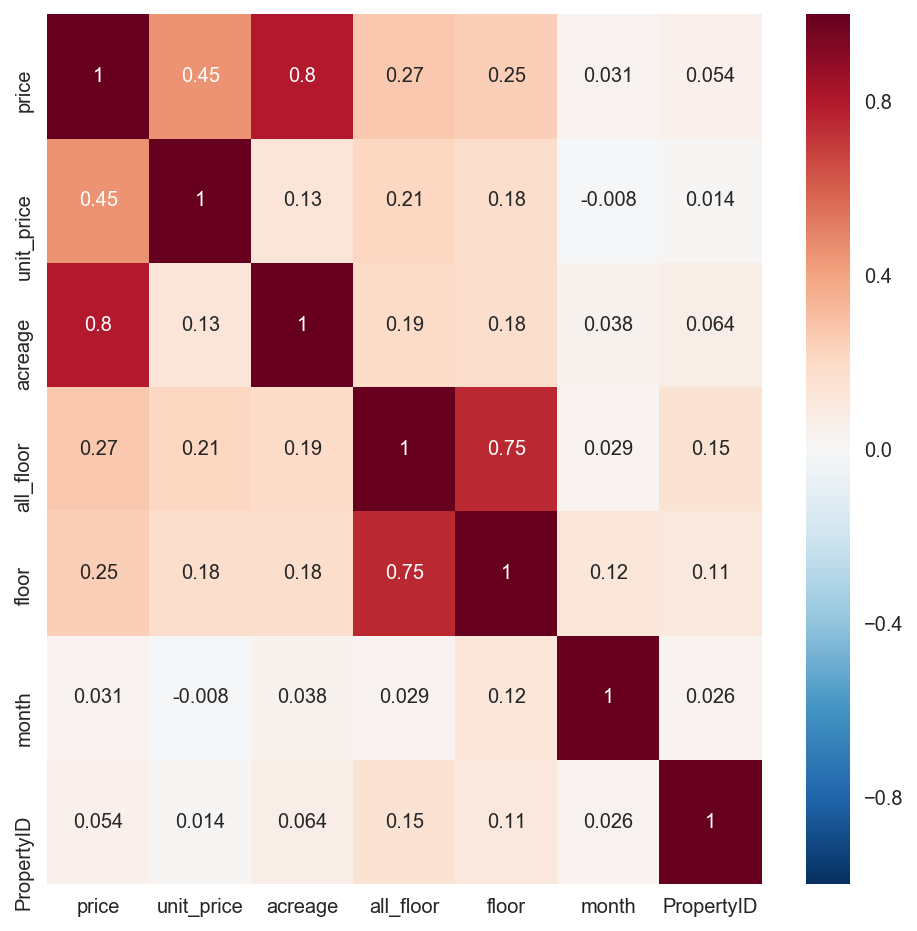

In [5]:
# 变量间相关性
sns.set({'figure.figsize':(8,8)})
sns.heatmap(all_df.corr(),annot=True)

## 特征预处理

* 修正面积

count    3.480067e+06
mean     9.601145e+01
std      7.650108e+01
min      2.100000e+00
25%      5.611000e+01
50%      7.992000e+01
75%      1.090000e+02
max      4.388000e+03
Name: acreage, dtype: float64


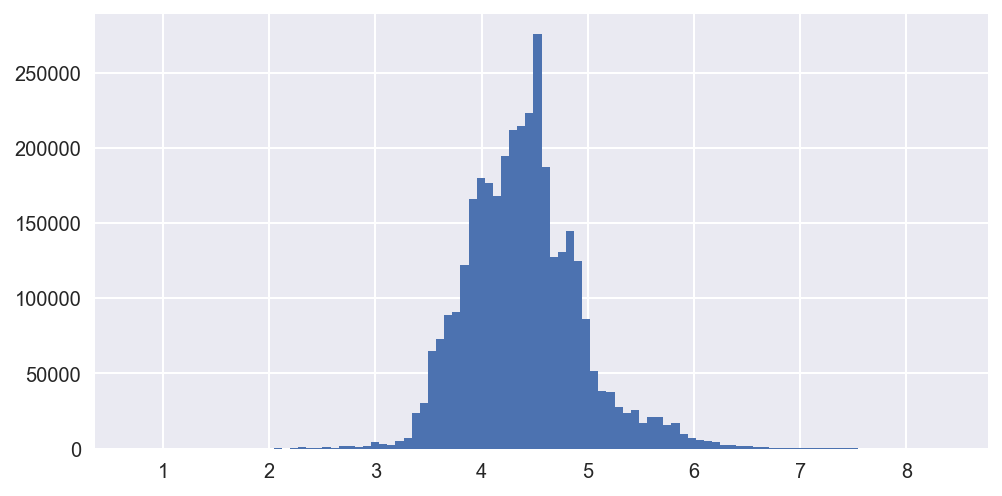

In [6]:
print(all_df.acreage.describe())
sns.set({'figure.figsize':(8,4)})
np.log(all_df.acreage).hist(bins=100) # log化处理偏态数据

In [7]:
# 计算偏度
print('修正前：%f'%skew(all_df.acreage))
print('修正后：%f'%skew(np.log(all_df.acreage)))

修正前：6.746596
修正后：0.598935


count    2.848865e+06
mean     9.263810e+01
std      3.678711e+01
min      4.739000e+01
25%      6.500000e+01
50%      8.500000e+01
75%      1.100000e+02
max      2.386600e+02
Name: acreage, dtype: float64

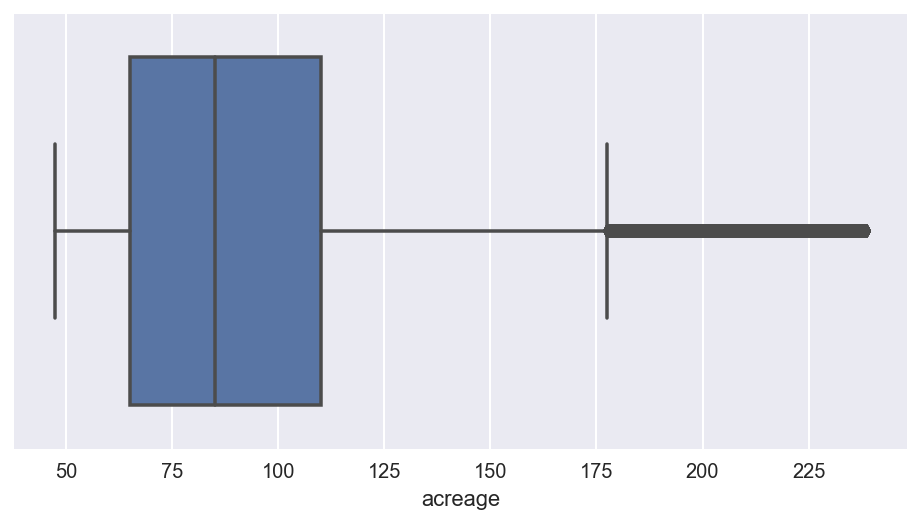

In [8]:
acreage_log=np.log(all_df.acreage)
mean=acreage_log.mean()
std=acreage_log.std()
i=acreage_log[(acreage_log<=mean+2*std)&(acreage_log>=mean-1*std)].index
sns.set({'figure.figsize':(8,4)})
sns.boxplot(all_df.loc[i].acreage)
all_df.loc[i].acreage.describe()

In [9]:
all_df=all_df.loc[i]

* 修正单价

count    2.848865e+06
mean     5.346441e+04
std      2.434708e+04
min      2.798000e+03
25%      3.958300e+04
50%      5.196100e+04
75%      6.440000e+04
max      9.523714e+06
Name: unit_price, dtype: float64


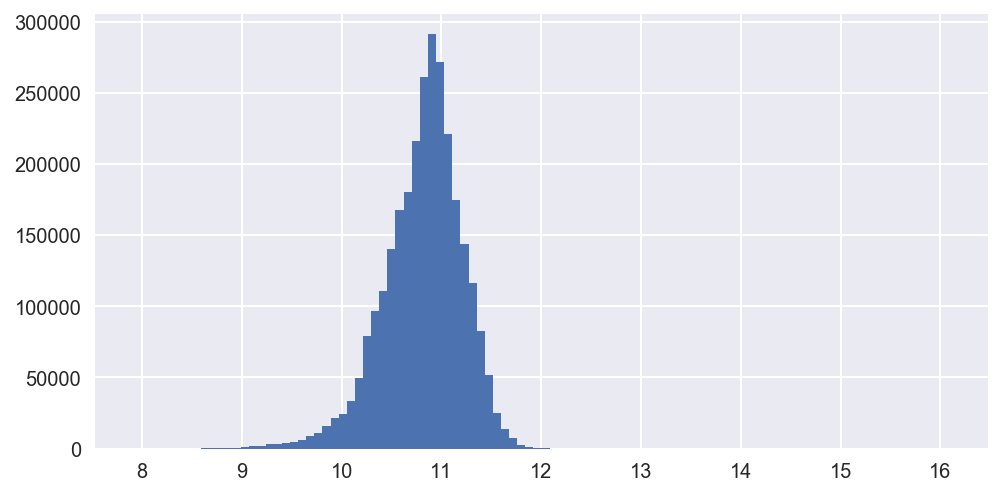

In [10]:
print(all_df.unit_price.describe())
np.log(all_df.unit_price).hist(bins=100)

In [11]:
# 计算偏度
print('修正前：%f'%skew(all_df.unit_price))
print('修正后：%f'%skew(np.log(all_df.unit_price)))

修正前：73.207969
修正后：-0.665131


count    2.827755e+06
mean     5.365555e+04
std      1.911448e+04
min      1.408300e+04
25%      3.987700e+04
50%      5.210100e+04
75%      6.451600e+04
max      1.621620e+05
Name: unit_price, dtype: float64

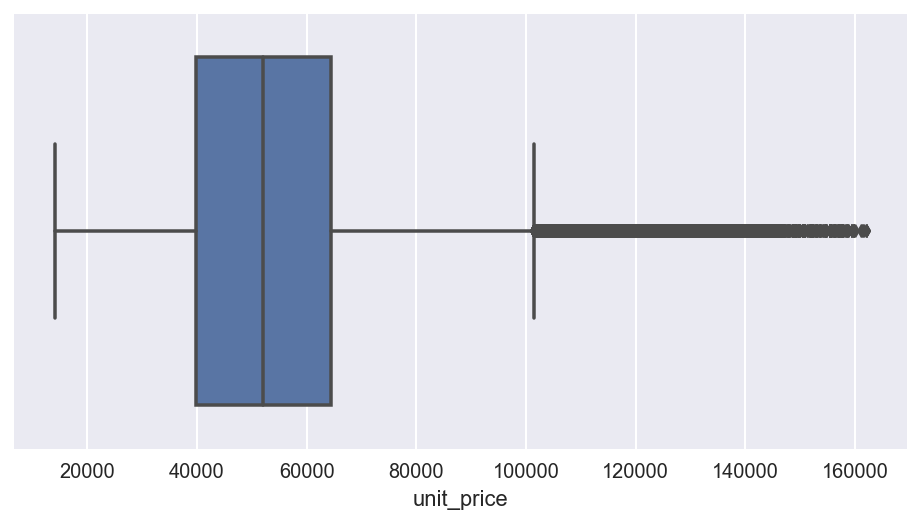

In [12]:
unit_price_log=np.log(all_df.unit_price)
mean=unit_price_log.mean()
std=unit_price_log.std()
i=unit_price_log[(unit_price_log<=mean+3*std)&(unit_price_log>=mean-3.2*std)].index
sns.set({'figure.figsize':(8,4)})
sns.boxplot(all_df.loc[i].unit_price)
all_df.loc[i].unit_price.describe()

In [13]:
all_df=all_df.loc[i]

* 修复总价

In [14]:
# 修复总价单位误差
all_df.loc[all_df.price<=10000,'price']*=10000

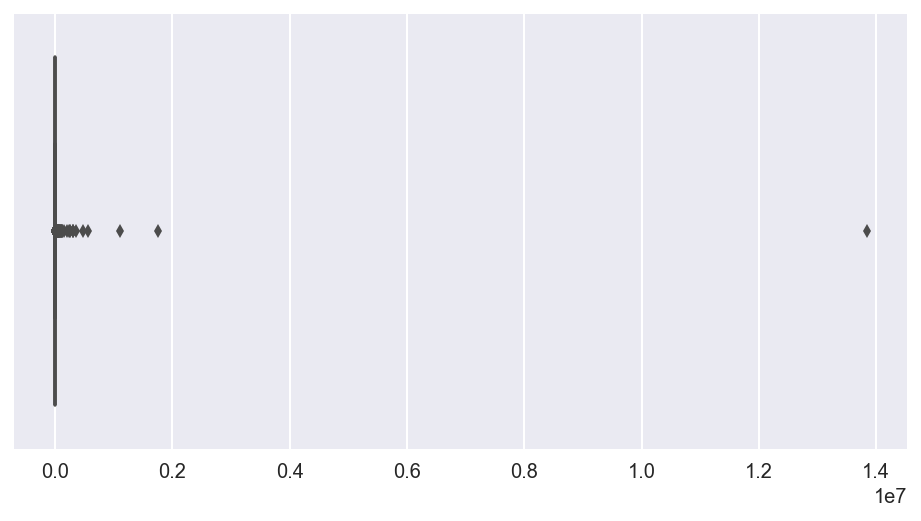

In [15]:
# 差价分布
anomaly_price=np.abs(all_df.unit_price*all_df.acreage-all_df.price)
sns.set({'figure.figsize':(8,4)})
sns.boxplot(anomaly_price)

In [16]:
anomaly_price_index=anomaly_price[anomaly_price>100000].index # 差价太多为异常点
anomaly_price[anomaly_price_index].sort_values()

1795577      100076.00
1174883      101466.30
2233382      106599.68
2898464      112371.50
1796312      120995.84
43695        123206.00
1370142      126760.80
3468122      158114.00
1767766      200370.20
1376031      232134.60
2604270      259993.22
2604285      259993.22
854398       300014.28
854082       300014.28
853961       300014.28
1887414      359189.47
2541108      478614.47
1006932      554942.00
902355      1100625.00
1378381     1757339.60
3456036    13837722.04
dtype: float64

In [17]:
# 修正异常的总价
# train.loc[anomaly_price_index,'price']=train.loc[anomaly_price_index,'unit_price']*train.loc[anomaly_price_index,'acreage']

# 直接删除异常样本
all_df.drop(anomaly_price_index,axis=0,inplace=True)

In [18]:
# 最便宜小区和最贵小区分布
i=all_df.price.sort_values()
all_df.loc[pd.concat((i.head(),i.tail())).index]

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,house_type,fitment,time,Source,house_trait,month,PropertyID,Plate,Module,Coordinates
3452572,奉贤,奉城邮电路421弄,奉铭佳苑,680000.0,14167.0,48.00,2室1厅1卫,19.0,14.0,南北,公寓,精装修,2011-01-01,房天下,普通住宅,9,15449,奉城,外环以外,"121.07160410165,30.937525261652"
3170884,嘉定,和静路1188弄,红湖小区,680000.0,14167.0,48.00,1室1厅1厨1卫,6.0,2.0,南,公寓,精装修,2000-01-01,房天下,普通住宅,3,3965,安亭汽车城,外环以外,"121.16581491967,31.307232256388"
3355468,奉贤,南明路191号,青村小镇,680000.0,14167.0,48.00,2室1厅1卫,6.0,4.0,南,公寓,精装修,2000-01-01,房天下,普通住宅,8,672,奉贤其它,外环以外,"121.5454573782,30.874789949594"
3355482,奉贤,南明路99号,青村小镇,680000.0,14167.0,48.00,2室1厅1卫,6.0,4.0,南,公寓,精装修,2000-01-01,房天下,普通住宅,8,672,奉贤其它,外环以外,"121.5454573782,30.874789949594"
3355530,奉贤,南明路99号,青村小镇,680000.0,14167.0,48.00,2室1厅1卫,6.0,4.0,南,公寓,精装修,2000-01-01,房天下,普通住宅,9,672,奉贤其它,外环以外,"121.5454573782,30.874789949594"
2926754,长宁,华山路1038弄,嘉里华庭,38000000.0,159771.0,237.84,4室2厅3卫,35.0,31.0,南,公寓,精装,2006-01-01,链家,公寓,6,12680,新华路,内环以内,"121.44243002127,31.218649238629"
2927247,长宁,华山路1038弄,嘉里华庭,38000000.0,159771.0,237.84,4室2厅,35.0,29.0,南,公寓,精装,2006-01-01,链家,住宅-公寓,9,12680,新华路,内环以内,"121.44243002127,31.218649238629"
2926685,长宁,华山路1038弄,嘉里华庭,38000000.0,159771.0,237.84,4室2厅3卫,35.0,24.0,南,公寓,精装,2006-01-01,链家,公寓,5,12680,新华路,内环以内,"121.44243002127,31.218649238629"
2926462,长宁,华山路1038弄166-170号,嘉里华庭,38000000.0,159771.0,237.84,4室2厅1厨3卫,35.0,11.0,南北,公寓,精装修,2005-01-01,房天下,普通住宅,4,12680,新华路,内环以内,"121.44243002127,31.218649238629"
2926315,长宁,华山路1038弄,嘉里华庭,38000000.0,159771.0,237.84,4室2厅3卫,35.0,29.0,南,公寓,精装,2006-01-01,链家,公寓,3,12680,新华路,内环以内,"121.44243002127,31.218649238629"


In [19]:
# 修复后，差价都在合理范围内?
np.abs(all_df.unit_price*all_df.acreage-all_df.price).sort_values(ascending=False)[:10]

1754267    89998.30
419321     81497.00
1036322    80280.00
1602669    78459.70
819614     75397.76
2590325    68875.00
242697     68750.00
1735994    62612.00
2443064    61506.25
1408511    60916.00
dtype: float64

* 地区因素

In [20]:
# 各地区的均价
all_df[['unit_price','area']].groupby('area').mean().sort_values('unit_price')

,unit_price
area,
金山,19944.453228
崇明,24161.149679
奉贤,26959.897533
青浦,32490.803562
嘉定,36166.079650
松江,36180.222787
宝山,45447.846827
闵行,47096.147112
浦东,55634.089680


          unit_price
Module              
外环以外    36630.411421
中外环间    53456.406572
内中环间    61522.008448
内环以内    74633.204999


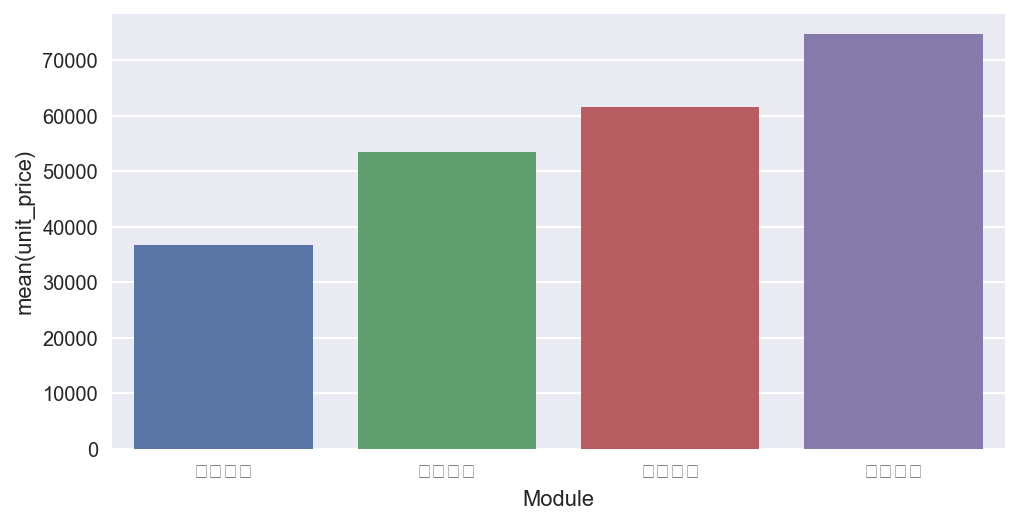

In [21]:
# 环线
all_df.loc[all_df[all_df.Module=='所有'].index,'Module']='内环以内'
sorted_module=all_df[['unit_price','Module']].groupby('Module').mean().sort_values('unit_price')
print(sorted_module)
sns.barplot(x=sorted_module.index,y='unit_price',data=sorted_module)

In [22]:
# id映射
i=pd.Series(range(0,sorted_module.shape[0]),index=sorted_module.index)
i.to_dict()

{'中外环间': 1, '内中环间': 2, '内环以内': 3, '外环以外': 0}

In [23]:
all_df.Module=all_df.Module.map(i.to_dict())

In [24]:
# 板块均价排序
all_df.groupby(['area','Plate'],as_index=False)['unit_price'].agg({'mean_price':'mean'}).sort_values('mean_price',ascending=False)

,area,Plate,mean_price
118,静安,南京西路,101690.139235
122,静安,江宁路,93659.761332
127,黄浦,黄浦滨江,92746.878046
75,浦东,联洋,92064.211643
125,黄浦,淮海中路,90570.883054
123,黄浦,人民广场,88484.018745
31,徐汇,徐汇滨江,84439.270609
80,浦东,陆家嘴,84054.709781
94,长宁,古北,80570.764804
124,黄浦,打浦桥,80185.976647


* 楼层因素

In [25]:
all_df[['all_floor','floor']].describe()

,all_floor,floor
count,2.827734e+06,2.827734e+06
mean,1.165609e+01,5.542646e+00
std,8.323804e+00,5.425400e+00
min,1.000000e+00,-5.000000e+00
25%,6.000000e+00,2.000000e+00
50%,6.000000e+00,4.000000e+00
75%,1.600000e+01,7.000000e+00
max,9.000000e+01,6.200000e+01


In [26]:
all_df.loc[all_df.floor<0,'floor']=np.nan

In [28]:
# 分段映射
all_df['floor_section']=floor_map(all_df.floor)

# 统计
all_df.groupby('floor_section',as_index=False)['floor_section'].agg({'count':'count'})

,floor_section,count
0,低层,1351903
1,多层,753097
2,小高层,259292
3,高层,460219


* 朝向因素

In [29]:
all_df.shore.unique()

array(['南北', '南', '东南', '', '西', '北', '东', '东西', '西北', '西南', '暂无', '东北',
       '暂无数据', '      '], dtype=object)

In [30]:
# 暂无为缺省字段
all_df.shore.replace({'暂无数据':'暂无','      ':'暂无','':'暂无'},inplace=True)
all_df.shore.unique()

array(['南北', '南', '东南', '暂无', '西', '北', '东', '东西', '西北', '西南', '东北'], dtype=object)

         unit_price
shore              
暂无     48782.679633
北      50138.356956
南北     52538.638495
南      55006.973440
东      60253.361448
东北     60258.427901
西北     65856.878815
东南     67386.994897
东西     69483.038531
西南     69977.788498
西      70376.650338


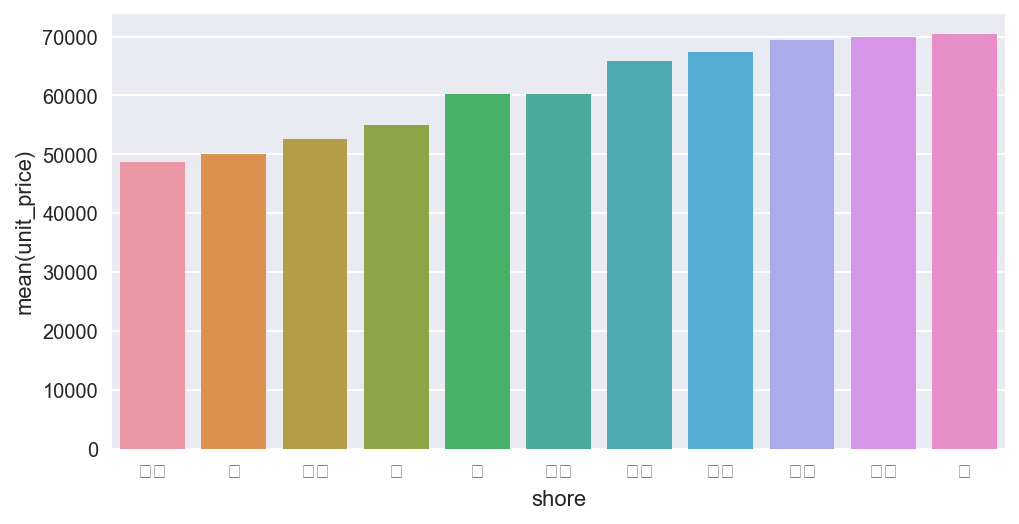

In [31]:
sorted_shore=all_df[['unit_price','shore']].groupby('shore').mean().sort_values('unit_price')
print(sorted_shore)
sns.barplot(x=sorted_shore.index,y='unit_price',data=sorted_shore)

In [32]:
i=pd.Series(range(0,sorted_shore.shape[0]),index=sorted_shore.index)
i.to_dict()

{'东': 4,
 '东北': 5,
 '东南': 7,
 '东西': 8,
 '北': 1,
 '南': 3,
 '南北': 2,
 '暂无': 0,
 '西': 10,
 '西北': 6,
 '西南': 9}

In [33]:
all_df.shore=all_df.shore.map(i.to_dict())

* 房屋类型

In [34]:
all_df.house_type.unique()

array(['公寓', '商铺', '别墅洋房', '办公楼', '其它', '里弄房'], dtype=object)

In [35]:
# 统计计数
all_df.house_type.value_counts()

公寓      2768417
别墅洋房      40838
商铺        17484
办公楼         652
其它          299
里弄房          44
Name: house_type, dtype: int64

In [36]:
all_df.loc[all_df[(all_df.house_type=='其它') | (all_df.house_type=='工厂')].index,'house_type']='公寓'
all_df.house_type.unique()

array(['公寓', '商铺', '别墅洋房', '办公楼', '里弄房'], dtype=object)

In [37]:
sorted_house_type=all_df[['house_type','unit_price']].groupby('house_type').mean().sort_values('unit_price')
sorted_house_type

,unit_price
house_type,
办公楼,37708.558282
别墅洋房,42080.108551
公寓,53812.589408
商铺,56390.958762
里弄房,60121.522727


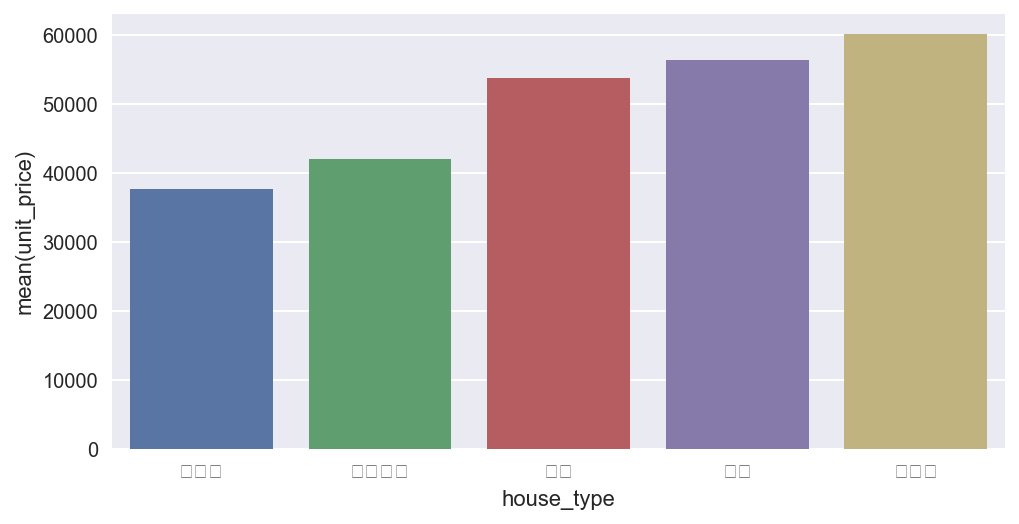

In [38]:
sns.barplot(x=sorted_house_type.index,y='unit_price',data=sorted_house_type)

In [39]:
i=pd.Series(range(0,sorted_house_type.shape[0]),index=sorted_house_type.index)
i.to_dict()

{'公寓': 2, '别墅洋房': 1, '办公楼': 0, '商铺': 3, '里弄房': 4}

In [40]:
all_df.house_type=all_df.house_type.map(i.to_dict())

* 装修情况

In [41]:
all_df.fitment.unique()

array(['中装修', '简装修', '精装修', '毛坯', '简装', '中装', '豪华装修', '精装', '豪装', '',
       '暂无数据', '暂无'], dtype=object)

In [42]:
# 缺省字段填充
default_fit='暂无'
all_df.fitment.replace({'':default_fit,'暂无数据':default_fit,'豪华装':'豪装'},inplace=True)
all_df.fitment=all_df.fitment.apply(lambda x:x.strip('修'))
all_df.fitment.unique()

array(['中装', '简装', '精装', '毛坯', '豪华装', '豪装', '暂无'], dtype=object)

         unit_price
fitment            
毛坯          37143.0
简装          51835.5
精装          52276.0
中装          53421.0
暂无          55126.0
豪华装         61871.0
豪装          68160.0


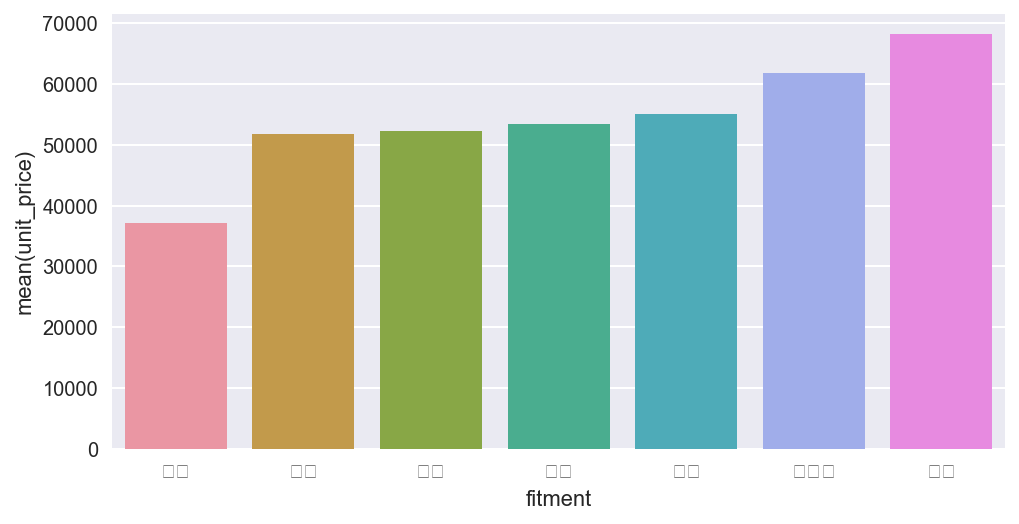

In [43]:
sorted_fitment=all_df[['fitment','unit_price']].groupby('fitment').median().sort_values('unit_price')
print(sorted_fitment)
sns.barplot(x=sorted_fitment.index,y='unit_price',data=sorted_fitment)

In [44]:
i=pd.Series(range(0,sorted_fitment.shape[0]),index=sorted_fitment.index)
i.to_dict()

{'中装': 3, '暂无': 4, '毛坯': 0, '简装': 1, '精装': 2, '豪华装': 5, '豪装': 6}

In [45]:
all_df.fitment=all_df.fitment.map(i.to_dict())

* 房型

In [46]:
import re

# 正则提取房型数据
r=re.compile('室|厅|厨|卫')
l=[map(int,r.split(i)[:-1]) for i in all_df.room_type]
room_type_df=pd.DataFrame(l,index=all_df.index,columns=['室','厅','厨','卫'])

In [47]:
# idx=room_type_df[room_type_df['卫'].isnull()].index
# room_type_df.loc[idx,'卫']=room_type_df.loc[idx,'厨']
# room_type_df.loc[idx,'厨']=np.nan

In [48]:
from sklearn.preprocessing import Imputer

# 中位数填补
# imp = Imputer(missing_values='NaN', strategy='median', axis=0) 
# room_type_df[['室','厅','厨','卫']]=imp.fit_transform(room_type_df[['室','厅','厨','卫']])

# 零填补
# room_type_df.fillna(0)
# room_type_df.describe()

In [2]:
all_df=pd.concat((all_df,room_type_df),axis=1)
all_df.head()

* 时间

In [50]:
sorted(all_df.time.unique())

['1901-01-01',
 '1905-01-01',
 '1906-01-01',
 '1910-01-01',
 '1912-01-01',
 '1913-01-01',
 '1914-01-01',
 '1918-01-01',
 '1920-01-01',
 '1922-01-01',
 '1923-01-01',
 '1924-01-01',
 '1925-01-01',
 '1926-01-01',
 '1928-01-01',
 '1929-01-01',
 '1930-01-01',
 '1931-01-01',
 '1932-01-01',
 '1933-01-01',
 '1934-01-01',
 '1935-01-01',
 '1936-01-01',
 '1937-01-01',
 '1938-01-01',
 '1939-01-01',
 '1940-01-01',
 '1941-01-01',
 '1942-01-01',
 '1945-01-01',
 '1946-01-01',
 '1947-01-01',
 '1948-01-01',
 '1949-01-01',
 '1950-01-01',
 '1951-01-01',
 '1952-01-01',
 '1953-01-01',
 '1954-01-01',
 '1955-01-01',
 '1956-01-01',
 '1957-01-01',
 '1958-01-01',
 '1959-01-01',
 '1960-01-01',
 '1961-01-01',
 '1962-01-01',
 '1963-01-01',
 '1964-01-01',
 '1965-01-01',
 '1966-01-01',
 '1967-01-01',
 '1968-01-01',
 '1969-01-01',
 '1970-01-01',
 '1971-01-01',
 '1972-01-01',
 '1973-01-01',
 '1974-01-01',
 '1975-01-01',
 '1976-01-01',
 '1977-01-01',
 '1978-01-01',
 '1979-01-01',
 '1980-01-01',
 '1981-01-01',
 '1982-01-

In [51]:
all_df.time=all_df.time.apply(lambda x:x.split('-')[0]).astype(int)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

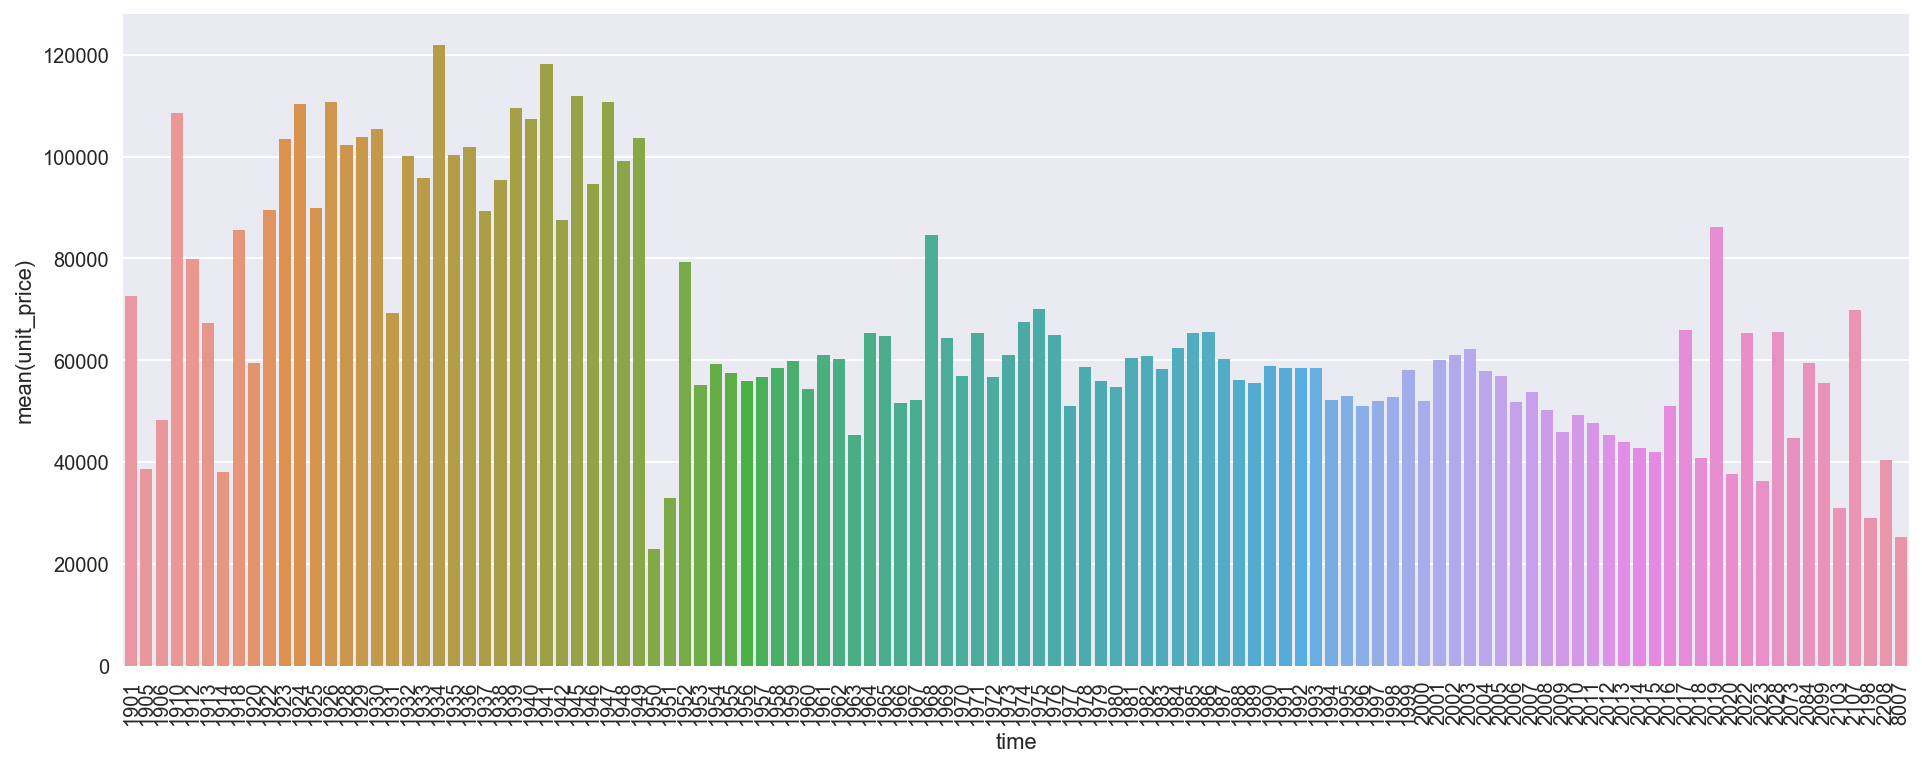

In [52]:
# 房价与单价关系
time_unit_price=all_df[['unit_price','time']].groupby('time').mean()
sns.set({'figure.figsize':(18,6)})
sns.barplot(x=time_unit_price.index,y='unit_price',data=time_unit_price)
plt.xticks(rotation=90)

In [2]:
all_df.time=all_df.time.apply(lambda x:2017-x if x<=2017 else 0)

NameError: name 'all_df' is not defined

In [3]:
# 房龄分布
sns.set({'figure.figsize':(10,4)})
all_df.time.hist(bins=100)

NameError: name 'all_df' is not defined

* 经纬度

In [153]:
coors=pd.DataFrame([coor.split(',') for coor in all_df.Coordinates],columns=['loc_x','loc_y'],index=all_df.index)
coors=coors.astype(float)
coors.head()

,loc_x,loc_y
0,121.708554,31.198135
1,121.708554,31.198135
2,121.708554,31.198135
3,121.708554,31.198135
4,121.708554,31.198135


In [154]:
all_df=pd.concat((all_df,coors),axis=1).drop('Coordinates',axis=1)
all_df.head()

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,...,PropertyID,Plate,Module,floor_section,室,厅,厨,卫,loc_x,loc_y
0,浦东,城南路359号,东都小区,1920000.0,39024.0,49.2,2室1厅1厨1卫,5.0,4.0,2,...,4781,川沙,0,多层,2.0,1.0,1.0,1.0,121.708554,31.198135
1,浦东,城南路329弄,东都小区,1900000.0,38618.0,49.2,2室1厅1厨1卫,6.0,2.0,2,...,4781,川沙,0,低层,2.0,1.0,1.0,1.0,121.708554,31.198135
2,浦东,城南路341弄,东都小区,1920000.0,38400.0,50.0,2室1厅1厨1卫,6.0,2.0,2,...,4781,川沙,0,低层,2.0,1.0,1.0,1.0,121.708554,31.198135
3,浦东,城南路359号,东都小区,1850000.0,37000.0,50.0,1室1厅1厨1卫,6.0,6.0,2,...,4781,川沙,0,多层,1.0,1.0,1.0,1.0,121.708554,31.198135
4,浦东,城南路359号,东都小区,1920000.0,39184.0,49.0,2室1厅1厨1卫,5.0,4.0,3,...,4781,川沙,0,多层,2.0,1.0,1.0,1.0,121.708554,31.198135


In [190]:
# 缓存特征矩阵
all_df.to_hdf('./cache/feats.hdf','data')

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['area', 'address', 'name', 'room_type', 'Source', 'house_trait', 'Plate', 'floor_section']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [4]:
all_df=pd.read_hdf('./cache/feats.hdf','data')
all_df.head()

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,...,PropertyID,Plate,Module,floor_section,室,厅,厨,卫,loc_x,loc_y
0,浦东,城南路359号,东都小区,1920000.0,39024.0,49.2,2室1厅1厨1卫,5.0,4.0,2,...,4781,川沙,0,多层,2.0,1.0,1.0,1.0,121.708554,31.198135
1,浦东,城南路329弄,东都小区,1900000.0,38618.0,49.2,2室1厅1厨1卫,6.0,2.0,2,...,4781,川沙,0,低层,2.0,1.0,1.0,1.0,121.708554,31.198135
2,浦东,城南路341弄,东都小区,1920000.0,38400.0,50.0,2室1厅1厨1卫,6.0,2.0,2,...,4781,川沙,0,低层,2.0,1.0,1.0,1.0,121.708554,31.198135
3,浦东,城南路359号,东都小区,1850000.0,37000.0,50.0,1室1厅1厨1卫,6.0,6.0,2,...,4781,川沙,0,多层,1.0,1.0,1.0,1.0,121.708554,31.198135
4,浦东,城南路359号,东都小区,1920000.0,39184.0,49.0,2室1厅1厨1卫,5.0,4.0,3,...,4781,川沙,0,多层,2.0,1.0,1.0,1.0,121.708554,31.198135


In [5]:
print('共有%d条训练数据'%all_df.shape[0])

共有2827734条训练数据


* 处理测试集

In [6]:
test_11=pd.read_excel('../../数据/楼盘基价_201711.xls')
test_12=pd.read_excel('../../数据/楼盘基价_201712.xlsx')
test_11['Month']=11
test_12['Month']=12
test_df=pd.concat((test_11,test_12))
test_df.head()

del test_11,test_12
gc.collect()

1497

In [7]:
print('11月份数据量:%d'%test_df[test_df.Month==11].shape[0])
print('12月份数据量:%d'%test_df[test_df.Month==12].shape[0])

11月份数据量:528
12月份数据量:620


In [8]:
# 去掉无信息数据后
test_df.dropna(inplace=True)
print('11月份数据量:%d'%test_df[test_df.Month==11].shape[0])
print('12月份数据量:%d'%test_df[test_df.Month==12].shape[0])

11月份数据量:497
12月份数据量:578


In [9]:
test_df.rename(columns={'楼盘名称':'name'},inplace=True)
test_df.name=test_df.name.apply(name_filter)

In [10]:
test_df.head()

,地址,房屋类型,竣工日期,所在楼层,总楼层,面积,正常价格,楼盘ID,name,Month
1,宝山区淞南九村220号101室,住宅,1997,1,6,69.40,47500,11922.0,淞南九村,11
2,宝山区淞南九村221号101室,住宅,1997,1,6,62.27,47500,11922.0,淞南九村,11
4,奉贤区青村镇北唐新苑21号401室,住宅,2006,4,4,127.66,16100,9824.0,北唐新苑,11
5,奉贤区西渡镇鸿宝二村别墅15幢全幢,花园住宅,1994,1,2,287.54,33000,5383.0,鸿宝二村,11
6,虹口区东体育会路992弄1号1202室,住宅,2002,12,29,141.63,72500,11021.0,曲阳豪庭,11


In [11]:
# 交集个数
len(set(test_df.name)&set(all_df.name))

584

## 模型训练

In [12]:
def make_train_test():
    """构造用于模型训练的训练集和测试集"""
    # 训练集
    x_train=all_df.drop(['area','unit_price','price','address','room_type','house_trait','month','Source','PropertyID'],axis=1)
    y_train=all_df.loc[x_train.index].unit_price
    # 计算小区房价中位数
    med_price=pd.concat((x_train.name,y_train),axis=1)
    med_price=med_price.groupby('name',as_index=False)['unit_price'].agg({'median':'median'})
    x_train=pd.merge(x_train,med_price,on='name',how='left')
    # 计算经纬度geohash信息
    geo=[]
    for i in tqdm(x_train[['loc_y','loc_x']].values):
        geo.append(encode(i[0],i[1],6))
    x_train['geo']=[i[:-1] for i in geo]

    # 测试集
    x_test=test_df[['竣工日期','所在楼层','总楼层','面积','正常价格','name']]
    x_test.columns=['time','floor','all_floor','acreage','unit_price','name']
    x_test=pd.merge(x_test,x_train.drop(['time','acreage','floor','all_floor'],axis=1),on='name',how='left').dropna()
    x_test['floor_section']=floor_map(x_test.floor)
    x_test['time']=x_test.time.apply(lambda x:int(x.strip('年')) if type(x)==str else int(x))
    x_test['time']=x_test.time.apply(lambda x:2017-x if x<=2017 else 0)
    y_test=x_test.unit_price
    x_test.drop('unit_price',axis=1,inplace=True)
    return x_train,y_train,x_test,y_test

* LightGBM

In [13]:
x_train,y_train,x_test,y_test=make_train_test()

# 将离散型变量转换成整型，用于lgb训练
from sklearn.preprocessing import LabelEncoder

name_le=LabelEncoder() # 小区名
plate_le=LabelEncoder() # 小板块
geo_le=LabelEncoder() # 经纬度

x_train.name=name_le.fit_transform(x_train.name)
x_test.name=name_le.transform(x_test.name)

x_train.Plate=plate_le.fit_transform(x_train.Plate)
x_test.Plate=plate_le.transform(x_test.Plate)

x_train.geo=geo_le.fit_transform(x_train.geo)
x_test.geo=geo_le.transform(x_test.geo)

section_map={'低层':0,'小高层':1,'多层':2,'高层':3}
x_train.floor_section=x_train.floor_section.replace(section_map)
x_test.floor_section=x_test.floor_section.replace(section_map)

x_train.drop('name',inplace=True,axis=1)
x_test.drop('name',inplace=True,axis=1)

100%|██████████| 2827734/2827734 [00:43<00:00, 65051.71it/s]


In [89]:
# 分割训练/验证集
x1,x2,y1,y2=train_test_split(x_train,y_train,train_size=0.9,random_state=0)

# 缩放标签数据
# price_zoom=10000
# y1/=price_zoom
# y2/=price_zoom

# 删除重要性较低的特征
# x1.drop(['house_type','Module','floor_section'],axis=1,inplace=True)
# x2.drop(['house_type','Module','floor_section'],axis=1,inplace=True)

In [134]:
%%time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate':0.2,
    'feature_fraction': 0.6,
    'max_depth': 14,
    'num_leaves':220,
    'bagging_fraction': 0.6,
    'bagging_freq':5,
    'min_data_in_leaf':10,
    'min_gain_to_split':0,
    'lambda_l1':1,
    'lambda_l2':1,
    'verbose':0,
}

val_loss=[]

def eval_error(pred, df):
    """自定义评价函数"""
    score = mean_squared_error(df.get_label(),pred)
    val_loss.append(score)
    return ('mse',score,False)

lgb_train = lgb.Dataset(x1,y1,categorical_feature=['geo','Plate','floor_section'])
lgb_val=lgb.Dataset(x2,y2,reference=lgb_train)
# gbm = lgb.cv(params,lgb_train,num_boost_round=3000,early_stopping_rounds=20,feval=eval_error,nfold=3)
gbm = lgb.train(params,lgb_train,num_boost_round=450,valid_sets=lgb_val,early_stopping_rounds=10,feval=eval_error)

/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1007: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['Plate', 'floor_section', 'geo']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's l2: 3.61595e+08	valid_0's mse: 3.61595e+08
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.58988e+08	valid_0's mse: 3.58988e+08
[3]	valid_0's l2: 3.56333e+08	valid_0's mse: 3.56333e+08
[4]	valid_0's l2: 3.536e+08	valid_0's mse: 3.536e+08
[5]	valid_0's l2: 3.51028e+08	valid_0's mse: 3.51028e+08
[6]	valid_0's l2: 3.48322e+08	valid_0's mse: 3.48322e+08
[7]	valid_0's l2: 3.45765e+08	valid_0's mse: 3.45765e+08
[8]	valid_0's l2: 3.43199e+08	valid_0's mse: 3.43199e+08
[9]	valid_0's l2: 3.40663e+08	valid_0's mse: 3.40663e+08
[10]	valid_0's l2: 3.3802e+08	valid_0's mse: 3.3802e+08
[11]	valid_0's l2: 3.35401e+08	valid_0's mse: 3.35401e+08
[12]	valid_0's l2: 3.32906e+08	valid_0's mse: 3.32906e+08
[13]	valid_0's l2: 3.30317e+08	valid_0's mse: 3.30317e+08
[14]	valid_0's l2: 3.27751e+08	valid_0's mse: 3.27751e+08
[15]	valid_0's l2: 3.25204e+08	valid_0's mse: 3.25204e+08
[16]	valid_0's l2: 3.22774e+08	valid_0's mse: 3.22774e+08
[17]	valid_0's l2: 3.2041

[142]	valid_0's l2: 1.21036e+08	valid_0's mse: 1.21036e+08
[143]	valid_0's l2: 1.20183e+08	valid_0's mse: 1.20183e+08
[144]	valid_0's l2: 1.1932e+08	valid_0's mse: 1.1932e+08
[145]	valid_0's l2: 1.18417e+08	valid_0's mse: 1.18417e+08
[146]	valid_0's l2: 1.17595e+08	valid_0's mse: 1.17595e+08
[147]	valid_0's l2: 1.16779e+08	valid_0's mse: 1.16779e+08
[148]	valid_0's l2: 1.15895e+08	valid_0's mse: 1.15895e+08
[149]	valid_0's l2: 1.1501e+08	valid_0's mse: 1.1501e+08
[150]	valid_0's l2: 1.1422e+08	valid_0's mse: 1.1422e+08
[151]	valid_0's l2: 1.13373e+08	valid_0's mse: 1.13373e+08
[152]	valid_0's l2: 1.12599e+08	valid_0's mse: 1.12599e+08
[153]	valid_0's l2: 1.11767e+08	valid_0's mse: 1.11767e+08
[154]	valid_0's l2: 1.11003e+08	valid_0's mse: 1.11003e+08
[155]	valid_0's l2: 1.10254e+08	valid_0's mse: 1.10254e+08
[156]	valid_0's l2: 1.09436e+08	valid_0's mse: 1.09436e+08
[157]	valid_0's l2: 1.08626e+08	valid_0's mse: 1.08626e+08
[158]	valid_0's l2: 1.07837e+08	valid_0's mse: 1.07837e+08
[15

[282]	valid_0's l2: 5.53914e+07	valid_0's mse: 5.53914e+07
[283]	valid_0's l2: 5.51875e+07	valid_0's mse: 5.51875e+07
[284]	valid_0's l2: 5.50221e+07	valid_0's mse: 5.50221e+07
[285]	valid_0's l2: 5.48541e+07	valid_0's mse: 5.48541e+07
[286]	valid_0's l2: 5.46888e+07	valid_0's mse: 5.46888e+07
[287]	valid_0's l2: 5.44777e+07	valid_0's mse: 5.44777e+07
[288]	valid_0's l2: 5.43184e+07	valid_0's mse: 5.43184e+07
[289]	valid_0's l2: 5.41566e+07	valid_0's mse: 5.41566e+07
[290]	valid_0's l2: 5.40021e+07	valid_0's mse: 5.40021e+07
[291]	valid_0's l2: 5.37988e+07	valid_0's mse: 5.37988e+07
[292]	valid_0's l2: 5.35957e+07	valid_0's mse: 5.35957e+07
[293]	valid_0's l2: 5.34081e+07	valid_0's mse: 5.34081e+07
[294]	valid_0's l2: 5.32136e+07	valid_0's mse: 5.32136e+07
[295]	valid_0's l2: 5.30255e+07	valid_0's mse: 5.30255e+07
[296]	valid_0's l2: 5.28781e+07	valid_0's mse: 5.28781e+07
[297]	valid_0's l2: 5.26863e+07	valid_0's mse: 5.26863e+07
[298]	valid_0's l2: 5.25396e+07	valid_0's mse: 5.25396e+

[422]	valid_0's l2: 4.16083e+07	valid_0's mse: 4.16083e+07
[423]	valid_0's l2: 4.15664e+07	valid_0's mse: 4.15664e+07
[424]	valid_0's l2: 4.15259e+07	valid_0's mse: 4.15259e+07
[425]	valid_0's l2: 4.14814e+07	valid_0's mse: 4.14814e+07
[426]	valid_0's l2: 4.1436e+07	valid_0's mse: 4.1436e+07
[427]	valid_0's l2: 4.13886e+07	valid_0's mse: 4.13886e+07
[428]	valid_0's l2: 4.13449e+07	valid_0's mse: 4.13449e+07
[429]	valid_0's l2: 4.13113e+07	valid_0's mse: 4.13113e+07
[430]	valid_0's l2: 4.12736e+07	valid_0's mse: 4.12736e+07
[431]	valid_0's l2: 4.12379e+07	valid_0's mse: 4.12379e+07
[432]	valid_0's l2: 4.12028e+07	valid_0's mse: 4.12028e+07
[433]	valid_0's l2: 4.11694e+07	valid_0's mse: 4.11694e+07
[434]	valid_0's l2: 4.11265e+07	valid_0's mse: 4.11265e+07
[435]	valid_0's l2: 4.1096e+07	valid_0's mse: 4.1096e+07
[436]	valid_0's l2: 4.10625e+07	valid_0's mse: 4.10625e+07
[437]	valid_0's l2: 4.10203e+07	valid_0's mse: 4.10203e+07
[438]	valid_0's l2: 4.09831e+07	valid_0's mse: 4.09831e+07
[

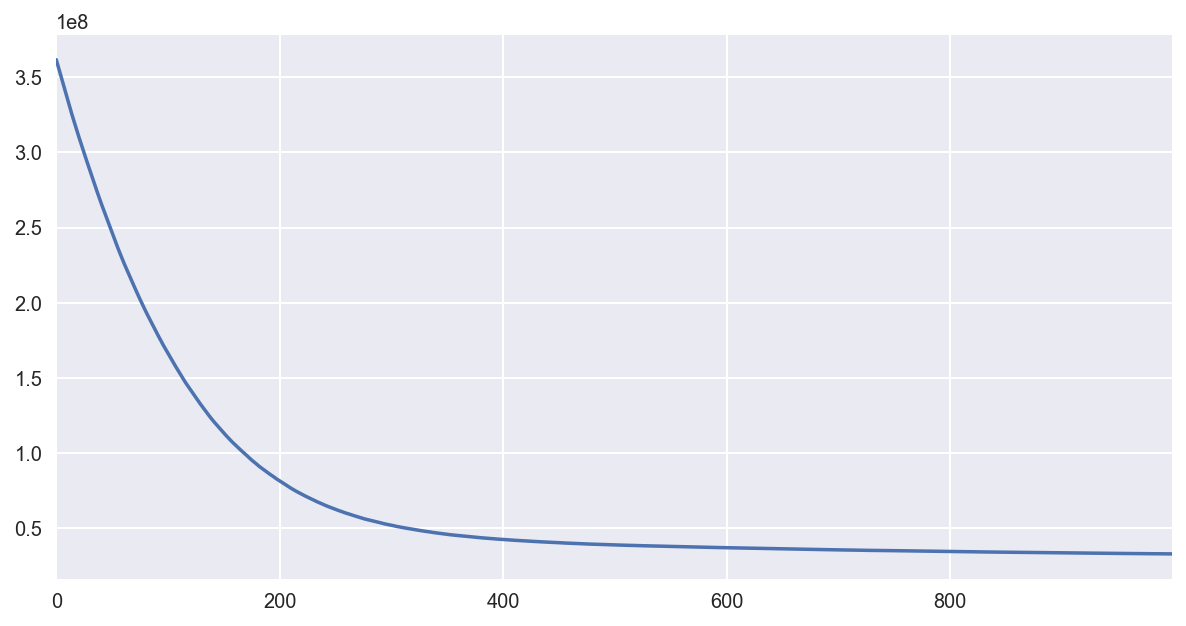

In [133]:
# 绘制测试集损失函数曲线
pd.Series(val_loss).plot()

In [121]:
# 保存模型
gbm.save_model('./cache/model.txt')

In [122]:
# 加载模型
gbm=lgb.Booster(model_file='./cache/model.txt')

In [135]:
# 测试误差
y_pred_test=gbm.predict(x_test)
mean_squared_error(y_pred_test,y_test)

58697072.900852956

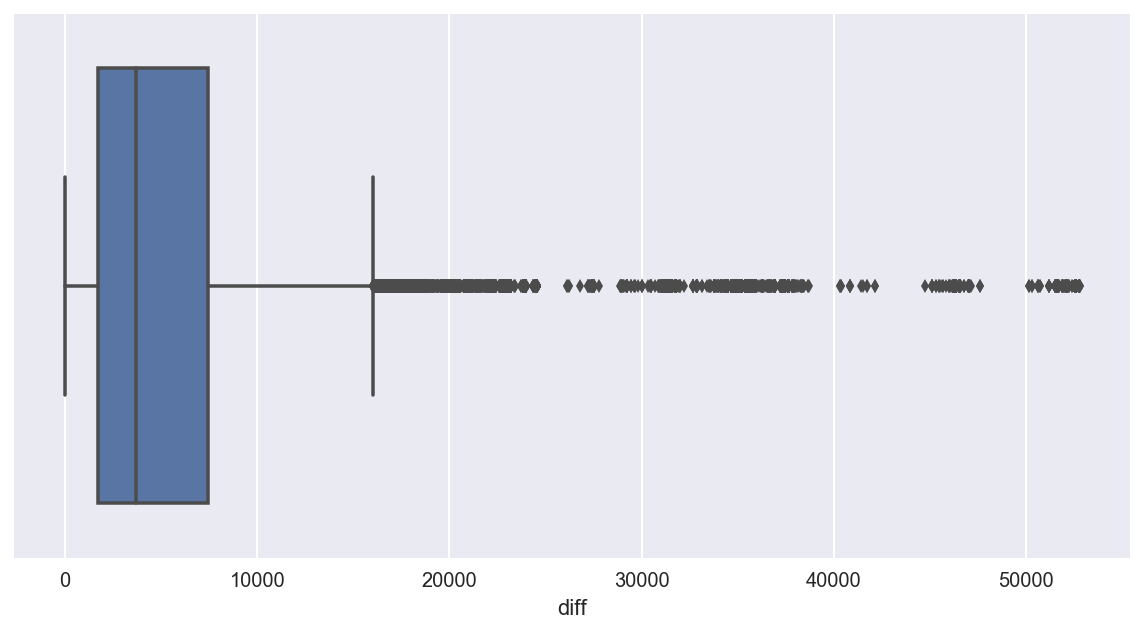

In [136]:
# 测试误差分布图
df_test=pd.DataFrame({'pred':y_pred_test,'true':y_test})
df_test['diff']=np.abs(df_test.pred-df_test.true)
sns.set({'figure.figsize':(10,5)})
sns.boxplot(df_test['diff'])

In [137]:
# 误差百分比统计
df_test['ratio']=(df_test['diff']/df_test.true)*100
pd.cut(df_test.ratio,[0,10,15,20,30,40,100]).value_counts()/df_test.shape[0]

(0, 10]      0.742357
(10, 15]     0.152729
(15, 20]     0.075603
(20, 30]     0.021440
(30, 40]     0.003211
(40, 100]    0.000157
Name: ratio, dtype: float64

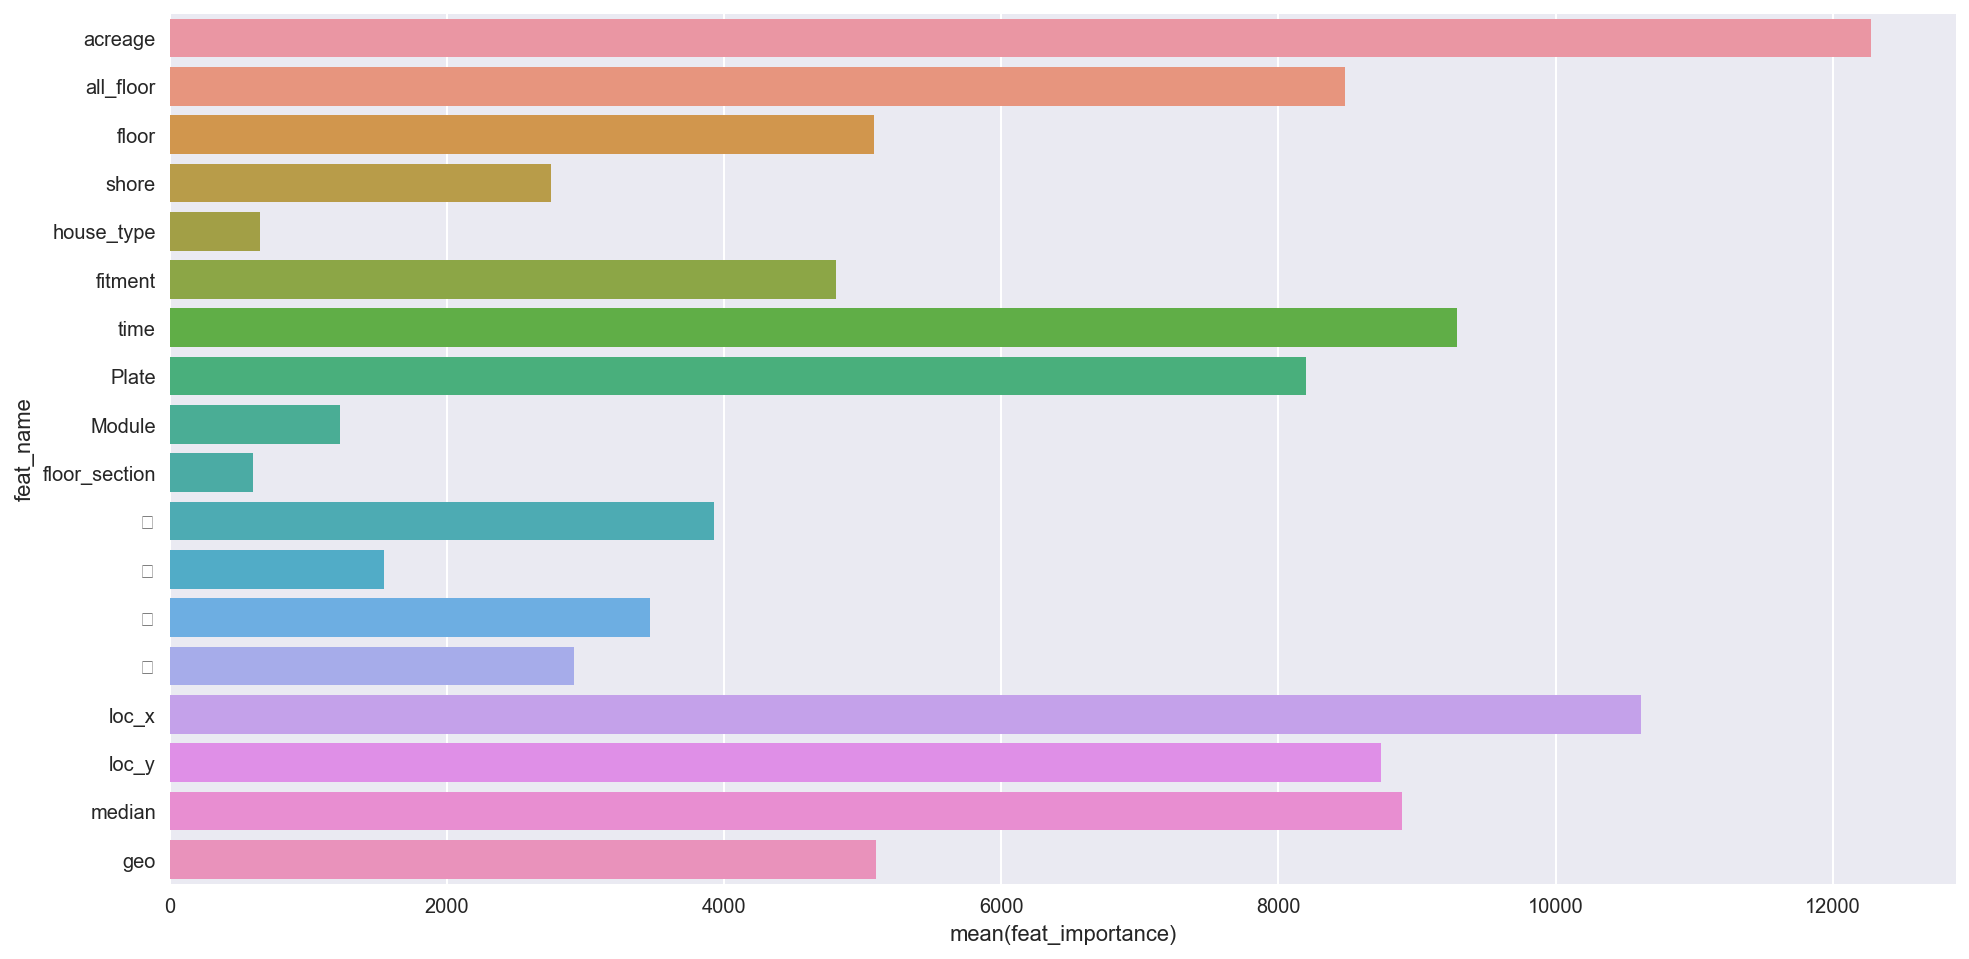

In [138]:
# 特征重要程度
sns.set({'figure.figsize':(16,8)})
sns.barplot(data=pd.DataFrame({'feat_name':x1.columns,'feat_importance':gbm.feature_importance()}),x='feat_importance',y='feat_name')

* Linear Regression (Incomplete)

In [41]:
x_train,y_train,x_test,y_test=make_train_test()

In [25]:
geo=[]
for i in tqdm(x_train[['loc_y','loc_x']].values):
    geo.append(encode(i[0],i[1],7))

100%|██████████| 2827734/2827734 [00:42<00:00, 65940.32it/s]


In [52]:
geo_df=pd.DataFrame({'geo_6':[i[:-1] for i in geo],'geo_7':geo},index=x_train.index)
geo_df.head()

,geo_6,geo_7
0,wtw93x,wtw93x3
1,wtw93x,wtw93x3
2,wtw93x,wtw93x3
3,wtw93x,wtw93x3
4,wtw93x,wtw93x3


In [54]:
x_train=pd.concat((x_train.drop(['name','loc_x','loc_y'],axis=1),geo_df[['geo_6']]),axis=1)

In [ ]:
geo_test=[]
for i in tqdm(x_test[['loc_y','loc_x']].values):
    geo_test.append(encode(i[0],i[1],7))

In [ ]:
geo_test_df=pd.DataFrame({'geo_6':[i[:-1] for i in geo_test],'geo_7':geo_test},index=x_test.index)
geo_df.head()

In [ ]:
from sklearn.linear_model import Lasso,Ridge

model=Ridge()
model.fit(pd.get_dummies(x_train),y_train)

In [ ]:
# 测试误差
y_pred_test=model.predict(x_test)
mean_squared_error(y_pred_test,y_test)